# Signal processing and time-frequency analysis

Signal processing is a fundamental component of any neuroscientific analysis, and sadly is one of the more poorly-taught fields out there (for scientists, anyway). Basically, this is just a way of manipulating and understanding signals (usually that vary in time). In predictive modeling of language, the two signals we tend to care about are ones that come from the brain (e.g., EEG, ECoG) and ones that come from our mouths (e.g., speech, language). Signal processing is a HUGE field, and in neuroscience we usually only scratch the surface. It’s most important to be familiar with these techniques, and particularly know when it might affect your data.

> The most basic package for doing this kind of thing in python is called “[scipy.signal](http://docs.scipy.org/doc/scipy/reference/signal.html)”. It’s the “signal” submodule of the scipy package. It’s got a lot of great features, though it can be more confusing than it needs to be.

In practice, it's often easier to use signal processing tools that have been pre-crafted for neuroscience analysis. A good place to start is [MNE-python](http://martinos.org/mne/stable/mne-python.html), which has a `time_frequency` module that has many of these functions in more user-friendly form. In particular, [these are some functions](http://martinos.org/mne/stable/python_reference.html#time-frequency) that can create spectrograms of sound or brain activity. I recommend checking out their "examples gallery" [here](http://martinos.org/mne/stable/auto_examples/index.html) to get an idea for what's possible.

Of particular interest to neuroscience are "time-frequency" decompositions. Extracting the frequency content of a signal allows you to take a time-domain signal (e.g., air pressure over time) into a frequency-domain signal (e.g., frequency power over frequency value). This tells us “how much” of each frequency is in the original signal.
In neuroscience, we do this on sliding windows of a signal, and slid those windows across time (computing the frequency representation each time) in order to build a spectrogram of the signal, aka, how the frequency content changes across time.

> To perform these things on a signal, check out the "periodogram" and "specgram" functions of pyplot. Also check out the time-frequency module that I linked to earlier.

In general, you need to provide the signal itself, as well as the sampling rate of the signal (e.g., how many points per second are we recording). This lets the function know the highest frequency that can be detected in the signal.

There are often other parameters to play around with, these often correspond to the parameters for the windows, or how the Fourier Transform is performed. Play around with them and see how it changes things.

A quick note - if you've got a 3-D matrix (e.g., a spectrogram that is time x frequency x amplitude), then a useful way of visualizing is to plot it as an image (aka, time and frequency are the two sides of the image, and the color intensity is the amplitude). Check out the "imshow" function for this.

## On to the data
For a first look at time-frequency processing, we'll first look at a raw audio file. This will show us how we can extract time-frequency information from a raw waveform. Then, we'll perform the same analysis on brain activity and see what there is to learn.

In [1]:
import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/choldgraf/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set fr

In [3]:
# Read in an MNE epochs file
data = mne.io.Raw('./data/audio_clean_raw.fif', add_eeg_ref=False)

In [5]:
# Load our times file, which is stored as a CSV of events
mtime = pd.read_csv('./data/time_info.csv', index_col=0)
mtime = mtime.query('t_type=="mid" and t_num > 0')

# We will create an "events" object by turning the start times into indices
# Then turning it into an array of shape (n_events, 3)
ev = mtime['start'] * data.info['sfreq']  # goes from seconds to index
ev = np.vstack([ev, np.zeros_like(ev), np.ones_like(ev)]).astype(int).T

# This is just a metadata dictionary.
# If we had multiple event types, we'd specify here.
einfo = dict(myevent=1)

/Users/choldgraf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/choldgraf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


array([[ 705782,       0,       1],
       [ 997045,       0,       1],
       [1230057,       0,       1],
       [1422567,       0,       1],
       [1702831,       0,       1]])

In [6]:
tmin, tmax = -.5, 2
epochs = mne.Epochs(data, ev, einfo, tmin, tmax,
                    baseline=(None, 0), preload=True)

# Note it's the same shape as before
print(epochs._data.shape)

(47, 1, 40001)


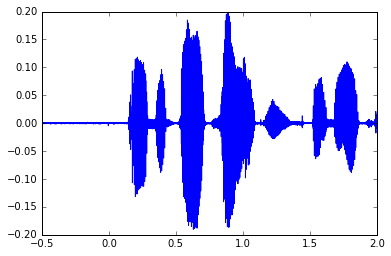

In [11]:
data_plt = epochs._data[0]
plt.plot(epochs.times, data_plt.T)

In [31]:
freqs = np.logspace(2, np.log10(5000), 128)
spec = mne.time_frequency.cwt_morlet(data_plt, epochs.info['sfreq'], freqs)

In [32]:
# Our output is now n_epochs x n_freqs _ time
spec.shape

(1, 128, 40001)

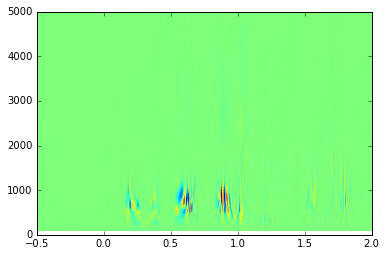

In [33]:
# And now we reveal the spectral content that was present in the sound
plt.pcolormesh(epochs.times, freqs, spec[0])

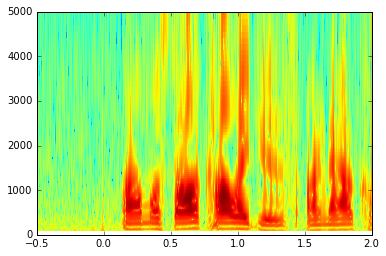

In [34]:
# Whoops, that looks pretty messy. Let's try taking the log...
f, ax = plt.subplots()
ax.pcolormesh(epochs.times, freqs, np.log(spec[0]))

Now we've revealed the underlying spectro-temporal structure that was present in the sound. By using a time-frequency decomposition, we've taken a really complicated looking time-varying signal, and we've revealed some interesting stuff that was happening under the surface. Let's do the same for our brain signal and see if we can gain similar insights.

## Brain activity

In [35]:
brain = mne.io.Raw('./data/ecog_clean_raw.fif', add_eeg_ref=False)

In [37]:
# We will create an "events" object by turning the start times into indices
# Then turning it into an array of shape (n_events, 3)
ev = mtime['start'] * brain.info['sfreq']  # goes from seconds to index
ev = np.vstack([ev, np.zeros_like(ev), np.ones_like(ev)]).astype(int).T

# This is just a metadata dictionary.
# If we had multiple event types, we'd specify here.
einfo = dict(myevent=1)

In [42]:
tmin, tmax = -.5, 2
brain_epochs = mne.Epochs(brain, ev, einfo, tmin, tmax,
                          baseline=(None, 0), preload=True)

# Note it's the same shape as before
print(brain_epochs._data.shape)

(47, 64, 2501)


In [43]:
# Pull a subset of epochs to speed things up
n_ep = 10
use_epochs = np.random.choice(range(len(brain_epochs)), replace=False, size=n_ep)
brain_epochs = brain_epochs[use_epochs]

In [46]:
# Data container
all_psd = []

# Default func
psd, freqs = mne.time_frequency.psd_welch(brain_epochs)
psd = pd.DataFrame(psd.mean(0), columns=freqs)
psd['kind'] = 'def'
psd.index.name = 'elec'
psd.set_index('kind', append=True, inplace=True)
all_psd.append(psd)

# Multitaper
psd = []
for ep in brain_epochs._data:
    ipsd, freqs = mne.time_frequency.multitaper._psd_multitaper(
        ep, sfreq=brain_epochs.info['sfreq'])
    psd.append(ipsd)
psd = np.array(psd)
psd = pd.DataFrame(psd.mean(0), columns=freqs)
psd.index.name = 'elec'
psd['kind'] = 'mt'
psd.set_index('kind', append=True, inplace=True)
all_psd.append(psd)

# Collect them
all_psd = pd.concat(all_psd, axis=0)
all_psd.columns.name = 'freq'

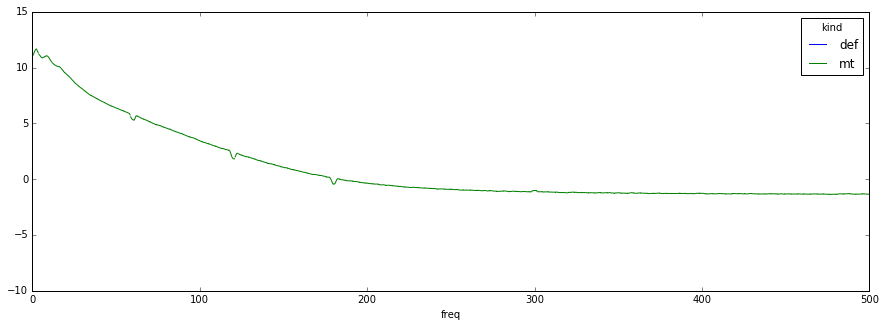

In [47]:
all_psd.apply(np.log).groupby(level='kind').mean().T.plot(figsize=(15, 5))

## TFR

In [92]:
freqs = np.logspace(1, np.log10(150), 20)
n_cycles = 5

In [ ]:
mne.time_frequency.tfr_multitaper()

In [104]:
tfr_funcs = {'mor': (mne.time_frequency.tfr_morlet, {'n_cycles': 5}),
             'mult': (mne.time_frequency.tfr_multitaper, {'n_cycles': 5})}

In [105]:
df_tfr = []
for nm, (func, kws) in tfr_funcs.iteritems():
    tfr, itc = func(data, freqs, **kws)
    for i, elec in enumerate(tfr.data):
        ielec = pd.DataFrame(elec, index=freqs, columns=data.times)
        ielec['elec'] = i
        ielec['kind'] = nm
        ielec.index.name = 'freq'
        ielec.set_index(['elec', 'kind'], inplace=True, append=True)
        df_tfr.append(ielec)
df_tfr = pd.concat(df_tfr)

Data is 10 trials and 20 channels
Multitaper time-frequency analysis for 20 frequencies
Using 3 tapers


In [106]:
df_tfr

,,,-2.0,-1.999,-1.998,-1.997,-1.996,-1.995,-1.994,-1.993,-1.992,-1.991,...,2.991,2.992,2.993,2.994,2.995,2.996,2.997,2.998,2.999,3.0
freq,elec,kind,,,,,,,,,,,,,,,,,,,,,
10.000000,0,mor,180789.086998,184007.557831,187242.916014,190494.192582,193760.398569,197040.525671,200333.546741,203638.416475,206954.071960,210279.433358,...,77857.955764,76675.816353,75498.070300,74324.958252,73156.721229,71993.600388,70835.836563,69683.670051,68537.340263,67397.085393
11.531865,0,mor,160897.018979,164145.752167,167409.982331,170688.272863,173979.162421,177281.166421,180592.778495,183912.472286,187238.703191,190569.910194,...,50579.153868,49990.604395,49393.641245,48788.606640,48175.855788,47555.756041,46928.685855,46295.033917,45655.198129,45009.584697
13.298390,0,mor,139935.945379,143258.627839,146599.632300,149956.846275,153328.110947,156711.224883,160103.947073,163504.000905,166909.077628,170316.840564,...,44469.624636,43964.519358,43443.559762,42907.422280,42356.801594,41792.408676,41214.968944,40625.220229,40023.910955,39411.798188
15.335524,0,mor,110379.300968,113524.227451,116694.518716,119887.539217,123100.563662,126330.781375,129575.301675,132831.159108,136095.319357,139364.685459,...,47103.696717,46248.971642,45384.528743,44511.422890,43630.711095,42743.449684,41850.691557,40953.483591,40052.864012,39149.860016
17.684719,0,mor,73339.226525,75802.007723,78292.960173,80809.599224,83349.313909,85909.370587,88486.916872,91078.986443,93682.504181,96294.292000,...,41327.329245,40302.763012,39279.819113,38259.560426,37243.026462,36231.231519,35225.162789,34225.778591,33234.006703,32250.742923
20.393779,0,mor,40081.425373,41581.662432,43102.930420,44643.650250,46202.144542,47776.638069,49365.258710,50966.038655,52576.915898,54195.736278,...,27676.751896,26924.429952,26175.093512,25429.437085,24688.141058,23951.870931,23221.276697,22496.992076,21779.633929,21069.801305
23.517830,0,mor,18854.823228,19558.052953,20269.883857,20989.802884,21717.288265,22451.807669,23192.815834,23939.751860,24692.035737,25449.064644,...,16126.439199,15747.219546,15364.197926,14977.694337,14588.062767,14195.690413,13800.996358,13404.429895,13006.468368,12607.614702
27.120443,0,mor,8839.288225,9104.792276,9368.224893,9629.684867,9889.353814,10147.493235,10404.439784,10660.598938,10916.436974,11172.471417,...,9762.193040,9598.181414,9424.824235,9242.306797,9050.891437,8850.914862,8642.784498,8426.974282,8204.019620,7974.511974
31.274928,0,mor,5148.344309,5258.699464,5361.253073,5456.159017,5543.703317,5624.300084,5698.484666,5766.904099,5830.304884,5889.518603,...,6075.766061,6008.735414,5932.519027,5847.079524,5752.459485,5648.782626,5536.253867,5415.158396,5285.859559,5148.795694
